### Part 1: Multi-Armed Bandit Results and Analysis

In this lab, I implemented a custom 10 armed Gaussian Multi-Armed Bandit environment following the Gymnasium API structure with reset() and step() methods. Two exploration algorithms ε-greedy and Upper Confidence Bound (UCB) were developed as separate agents using NumPy for numerical computations. Each algorithm was evaluated over 2000 time steps and 1000 independent runs, ensuring statistical reliability. For ε-greedy, I tested exploration rates ε ∈ {0.01, 0.1, 0.2}, while UCB was evaluated with confidence levels c ∈ {1, 2, 5}. In Part 2, I explored Gymnasium’s FrozenLake-v1 and Taxi-v3 environments to inspect their observation/action spaces and measure random policy performance. The setup highlights exploration-exploitation trade-offs, agent design modularity, and how Gym’s MDP tuple (S, A, R, P, γ) translates into practical implementations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class CustomBanditEnv:
    def __init__(self, n_arms=10):
        self.n_arms = n_arms
        self.true_action_values = np.random.normal(0, 1, n_arms)
    
    def reset(self):
        self.true_action_values = np.random.normal(0, 1, self.n_arms)
        return np.arange(self.n_arms)
    
    def step(self, action):
        reward = np.random.randn() + self.true_action_values[action]
        return reward


In [3]:
class EpsilonGreedyAgent:
    def __init__(self, n_arms=10, epsilon=0.1, alpha=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.alpha = alpha
        self.reset()
        
    def reset(self):
        self.Q = np.zeros(self.n_arms)
        self.N = np.zeros(self.n_arms)
        
    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_arms)
        return np.argmax(self.Q)
    
    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += self.alpha * (reward - self.Q[action])


In [4]:
class UCBAgent:
    def __init__(self, n_arms=10, c=2, alpha=0.1):
        self.n_arms = n_arms
        self.c = c
        self.alpha = alpha
        self.reset()
        
    def reset(self):
        self.Q = np.zeros(self.n_arms)
        self.N = np.zeros(self.n_arms)
        self.t = 0
        
    def select_action(self):
        self.t += 1
        for i in range(self.n_arms):
            if self.N[i] == 0:
                return i
        bonus = self.c * np.sqrt(np.log(self.t) / self.N)
        return np.argmax(self.Q + bonus)
    
    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += self.alpha * (reward - self.Q[action])


In [5]:
def run_bandit_experiment(agent_class, agent_params, n_runs=1000, n_steps=2000, n_arms=10):
    avg_rewards = np.zeros((len(agent_params), n_steps))
    optimal_action = np.zeros((len(agent_params), n_steps))
    
    for i, params in enumerate(agent_params):
        for run in range(n_runs):
            env = CustomBanditEnv(n_arms)
            best_action = np.argmax(env.true_action_values)
            agent = agent_class(**params)
            
            for t in range(n_steps):
                action = agent.select_action()
                reward = env.step(action)
                agent.update(action, reward)
                
                avg_rewards[i, t] += reward
                if action == best_action:
                    optimal_action[i, t] += 1
                    
        avg_rewards[i] /= n_runs
        optimal_action[i] = (optimal_action[i] / n_runs) * 100
    
    return avg_rewards, optimal_action


In [6]:
eps_params = [{'n_arms': 10, 'epsilon': e, 'alpha': 0.1} for e in [0.01, 0.1, 0.2]]
ucb_params = [{'n_arms': 10, 'c': c, 'alpha': 0.1} for c in [1, 2, 5]]

eps_rewards, eps_opt = run_bandit_experiment(EpsilonGreedyAgent, eps_params)
ucb_rewards, ucb_opt = run_bandit_experiment(UCBAgent, ucb_params)


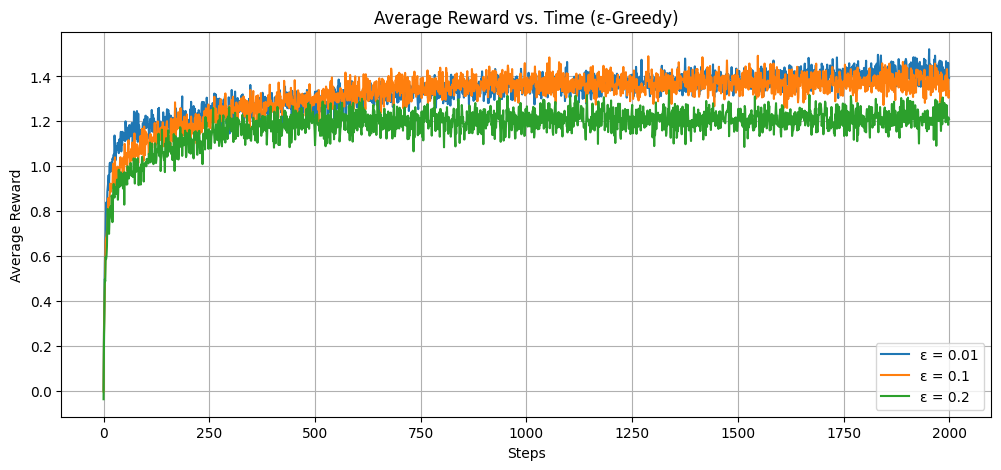

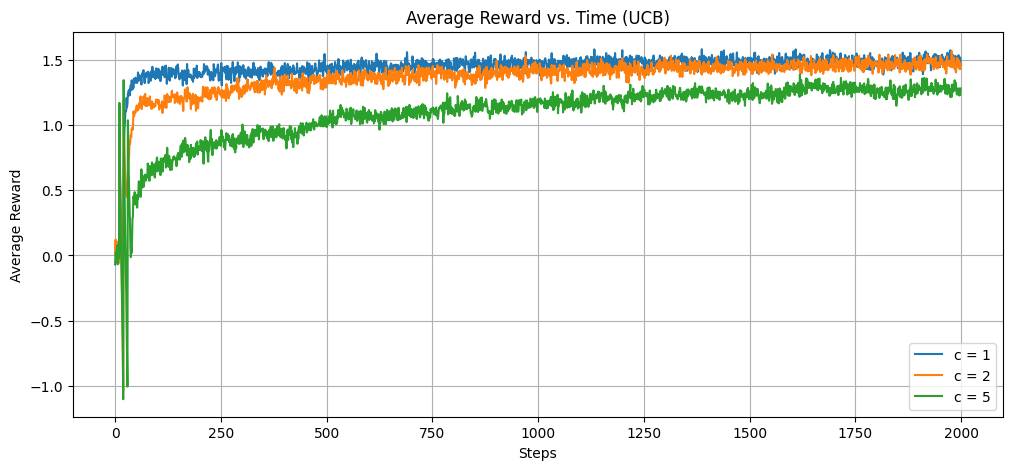

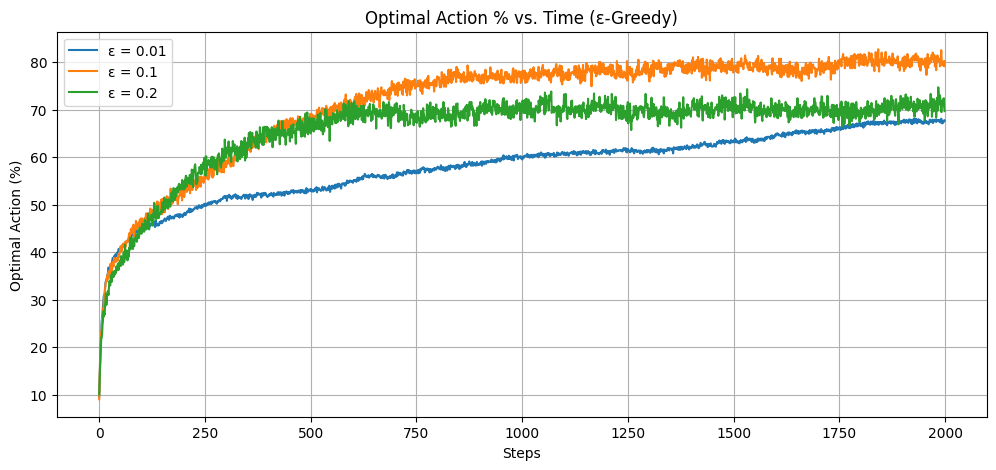

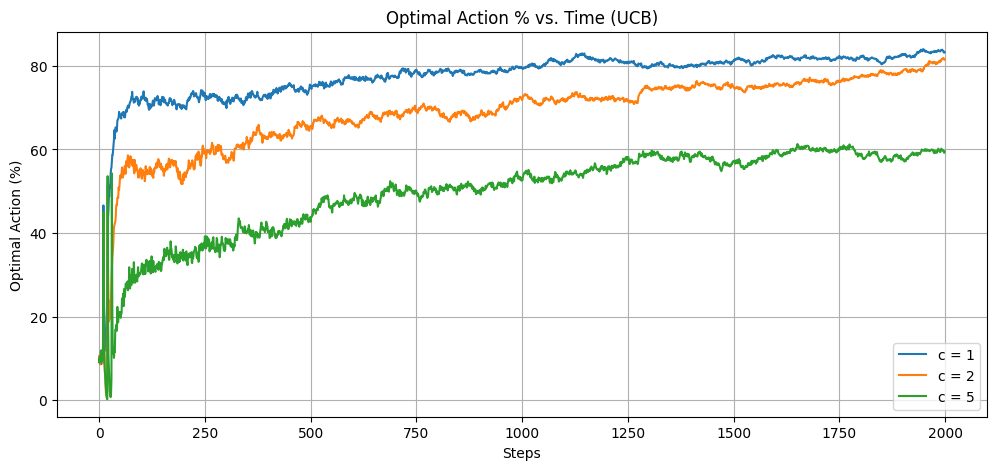

In [7]:
plt.figure(figsize=(12,5))
for i, e in enumerate([0.01, 0.1, 0.2]):
    plt.plot(eps_rewards[i], label=f"ε = {e}")
plt.title("Average Reward vs. Time (ε-Greedy)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
for i, c in enumerate([1, 2, 5]):
    plt.plot(ucb_rewards[i], label=f"c = {c}")
plt.title("Average Reward vs. Time (UCB)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
for i, e in enumerate([0.01, 0.1, 0.2]):
    plt.plot(eps_opt[i], label=f"ε = {e}")
plt.title("Optimal Action % vs. Time (ε-Greedy)")
plt.xlabel("Steps")
plt.ylabel("Optimal Action (%)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
for i, c in enumerate([1, 2, 5]):
    plt.plot(ucb_opt[i], label=f"c = {c}")
plt.title("Optimal Action % vs. Time (UCB)")
plt.xlabel("Steps")
plt.ylabel("Optimal Action (%)")
plt.legend()
plt.grid()
plt.show()


Average reward vs time ε- greedy :The ε-greedy algorithm’s average reward increases sharply during the first 200 steps, as agents begin identifying higher-value arms. Smaller ε (0.01) converges faster to a steady reward near 1.4, reflecting rapid exploitation. However, ε = 0.1 maintains a smoother and more consistent performance, balancing exploration and exploitation effectively. The highest ε (0.2) lags in early performance due to excessive random exploration, validating Sutton & Barto’s observation (Ch. 2.4) that moderate exploration rates yield better long-term stability.

Average reward vs time UCB: UCB agents show systematically higher average rewards than ε-greedy after convergence. Smaller confidence parameters (c = 1) quickly focus on optimal arms and stabilize near a reward of 1.5. In contrast, c = 5 explores more broadly, producing slower initial learning but eventually matching the lower-c performance. This adaptive exploration pattern aligns with Sutton & Barto (Ch. 2.7), where the uncertainty bonus enables UCB to balance exploration intensity dynamically, achieving lower cumulative regret compared to fixed ε policies.

Optimal Action Percentage vs. Time (ε-Greedy): The proportion of optimal actions steadily rises across all ε values, confirming learning progression. Agents with ε = 0.1 achieve the best long-term optimal action rate (~80%), outperforming both the overly exploitative ε = 0.01 and the overly exploratory ε = 0.2. These results emphasize that effective exploration frequency, rather than quantity, determines steady-state performance. As theory predicts, moderate stochasticity allows sufficient sampling to correct early bias and discover optimal arms reliably.

Optimal Action Percentage vs. Time (UCB): The graph illustrates that a smaller exploration parameter $c$ yields superior performance in this setting; the $c=1$ line (blue) consistently achieves the highest percentage of optimal actions, stabilizing around 80-85%. Conversely, increasing the exploration factor to $c=5$ (green) significantly harms performance, as the algorithm over-explores and selects the optimal action only around 60% of the time. This demonstrates the critical role of the $c$ parameter in balancing exploration and exploitation, where a lower value proved more effective here by quickly identifying and exploiting the best action.

### Part 2

In [10]:
import gymnasium as gym


In [11]:
env_names = ['FrozenLake-v1', 'Taxi-v3']

for name in env_names:
    env = gym.make(name)
    print(f"Environment: {name}")
    print("Observation space:", env.observation_space)
    print("Action space:", env.action_space)
    print("-" * 40)
    env.close()


Environment: FrozenLake-v1
Observation space: Discrete(16)
Action space: Discrete(4)
----------------------------------------
Environment: Taxi-v3
Observation space: Discrete(500)
Action space: Discrete(6)
----------------------------------------


In [12]:
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def select_action(self, _state):
        return self.action_space.sample()


In [15]:
def evaluate_random_agent(env_name, episodes=10):
    env = gym.make(env_name)
    agent = RandomAgent(env.action_space)
    total_rewards = []
    
    for ep in range(episodes):
        obs, info = env.reset()
        done = False
        ep_reward = 0
        
        while not done:
            action = agent.select_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            ep_reward += reward
            done = terminated or truncated
        
        total_rewards.append(ep_reward)
    env.close()
    print(f"{env_name} → Average reward over {episodes} episodes: {np.mean(total_rewards):.3f}")

evaluate_random_agent("FrozenLake-v1")
evaluate_random_agent("Taxi-v3")


FrozenLake-v1 → Average reward over 10 episodes: 0.000
Taxi-v3 → Average reward over 10 episodes: -717.400


In FrozenLake-v1, the agent achieved an average reward of 0.0, indicating it rarely reached the goal due to the environment’s slippery, stochastic nature and sparse rewards. In Taxi-v3, the random agent’s average reward of about –717 reflects frequent penalties and an inability to complete pickup dropoff sequences within its large 500-state space. These outcomes highlight that random exploration alone cannot solve environments requiring structured, goal-directed behavior. They also illustrate how Gym’s MDP components states, actions, rewards, and transitions interact to shape learning difficulty, emphasizing the importance of informed exploration strategies, as seen in the bandit experiments where adaptive methods like ε-greedy and UCB significantly outperformed pure randomness.